### Examining Fazekas Results
I have trained fazekas for DWMH and PVWMH for ADNI. Now lets compute accuracy and topk-2 accuracy, also do majority vote versions. (split ties to pick the lower class).

I have three sets to compare, ent, pred, both. (also I can compare seg and flair...). I should do two different policies: which one has highest accuracy on the valiatoin and which one has the best performance on the test (or majority vote across all seeds). Nice. I have controlled the seed so that the initialization is the same between models, so this should help me make better decisions

In [1]:
import torch
import matplotlib.pyplot as plt
import os

In [202]:
results_folder = "./results/ADNI/"
all_result_files = os.listdir(results_folder)

In [217]:
label = "WMH_Deep"
resdiv = 8
latentls = 3
decay = 0.1
reweighted = "true"
files = [f for f in all_result_files if label in f and f"resdiv{resdiv}" in f and f"latentls{latentls}" in f and f"decay{decay}" in f and f"{reweighted}" in f]

In [218]:
channel_types = ["both", "ent", "pred", "seg", "flair"]
names = ["umap + prediction", "umap", "prediction", "binarized prediction", "flair"]
channel_files = [[],[],[],[],[]]

for i, channel_id in enumerate(channel_types):
    for f in sorted(files):
        if f"_{channel_id}_" in f:
            channel_files[i].append(f)

In [219]:
channel_files

[['ADNI_WMH_Deep_both_0_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_both_1_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_both_2_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_both_3_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_both_4_resdiv8_latentls3_true_decay0.1'],
 ['ADNI_WMH_Deep_ent_0_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_ent_1_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_ent_2_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_ent_3_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_ent_4_resdiv8_latentls3_true_decay0.1'],
 ['ADNI_WMH_Deep_pred_0_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_pred_1_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_pred_2_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_pred_3_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_pred_4_resdiv8_latentls3_true_decay0.1'],
 ['ADNI_WMH_Deep_seg_0_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_seg_1_resdiv8_latentls3_true_decay0.1',
  'ADNI_WMH_Deep_s

In [220]:
def load_preds(file):
    with open(results_folder + file, 'r') as f:
        lines = f.readlines()
        
    lines = [l.split(": ")[1][:-1].split(", ") for l in lines] # turn into list of characters
    lines = [l[1:-1] for l in lines] # remove the [ and ] symbols
    lines = [torch.Tensor([float(v) for v in l]).type(torch.long) for l in lines]
    
    # order of lines is val pred, val labels, test pred, test labels
    return lines

In [221]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def plot_confusion_matrix_from_results(all_preds, all_labels, title, label, ds_name):    
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    num_classes = cm.shape[0]
    class_names = [str(i) for i in range(num_classes)]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, np.round(cm[i, j], 3),
                           ha="center", va="center", color="black")
            text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

    
    ax.set_title(f"Confusion Matrix:{label}\ninput:{title}")
    fig.tight_layout()
    plt.savefig(f"zfigs/{ds_name}_Confusion Matrix_{label}_input_{title}", bbox_inches='tight')
    plt.show()
    
    return cm

In [222]:
lines1 = load_preds("ADNI_WMH_Deep_both_0_resdiv8_latentls3_true_decay0.1")
lines2 = load_preds("ADNI_WMH_Deep_pred_3_resdiv8_latentls3_true_decay0.1")

In [223]:
def accuracies(lines):
    # return val accuracy and test accuracy
    return (lines[0] == lines[1]).sum().item() / len(lines[1]), (lines[2] == lines[3]).sum().item() / len(lines[3])

### NOTE TO SELF: I forgot to do model.eval() when collecting results!!!

In [224]:
best_idxs = []
for i, file_grp in enumerate(channel_files):
    max_idx = 0
    max_val_acc = 0
    max_test_acc = 0
    for idx, f in enumerate(file_grp):
        lines = load_preds(f)
        val_acc, test_acc = accuracies(lines)
        if val_acc > max_val_acc or (val_acc == max_val_acc and test_acc > max_test_acc):
            max_val_acc = val_acc
            max_idx = idx
            max_test_acc = test_acc 
        print(f"{channel_types[i]}, {val_acc:.3}, {test_acc:.3}")
    print(f"best idx: {max_idx}")
    best_idxs.append(max_idx)

both, 0.471, 0.46
both, 0.57, 0.511
both, 0.598, 0.515
both, 0.545, 0.504
both, 0.574, 0.529
best idx: 2
ent, 0.549, 0.507
ent, 0.57, 0.518
ent, 0.57, 0.526
ent, 0.52, 0.5
ent, 0.52, 0.5
best idx: 2
pred, 0.496, 0.504
pred, 0.529, 0.471
pred, 0.549, 0.511
pred, 0.549, 0.518
pred, 0.512, 0.489
best idx: 3
seg, 0.5, 0.489
seg, 0.529, 0.485
seg, 0.578, 0.504
seg, 0.578, 0.54
seg, 0.545, 0.496
best idx: 3
flair, 0.549, 0.526
flair, 0.402, 0.339
flair, 0.463, 0.427
flair, 0.426, 0.391
flair, 0.34, 0.343
best idx: 0


In [225]:
# # lower accuracy may mean better separation though... so I should do majority vote or mean or something
# # yes lets do majority vote....
# for i, file_grp in enumerate(channel_files):
#     best_idx = best_idxs[i]
#     lines = load_preds(file_grp[best_idx])
#     plot_confusion_matrix_from_results(lines[2], lines[3])
#     # break

In [226]:
grp_preds = []
grp_targets = []
for file_grp in channel_files:
    preds = []
    targets = []
    first = True
    for f in file_grp:
        lines = load_preds(f)
        if first:
            targets = lines[3]
            first = False
        preds.append(lines[2])
    
    if len(preds) > 0:
        grp_preds.append(torch.stack(preds))
        grp_targets.append(targets)

In [227]:
mode_preds = [p.mode(dim=0)[0] for p in grp_preds]

In [228]:
mean_preds = [p.type(torch.float32).mean(dim=0).round() for p in grp_preds]

In [229]:
#mean_preds

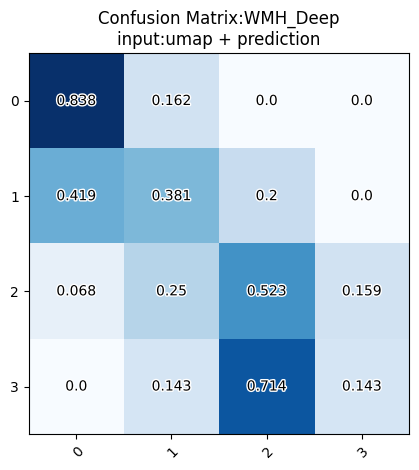

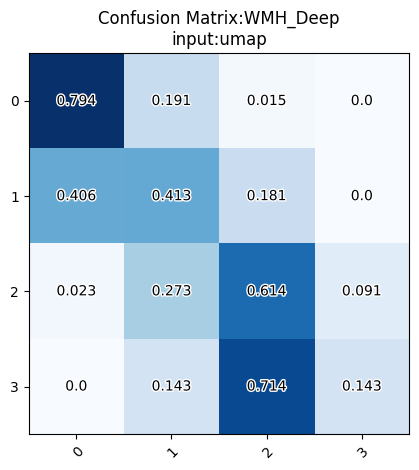

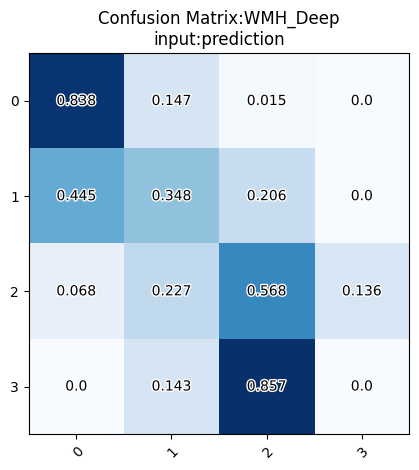

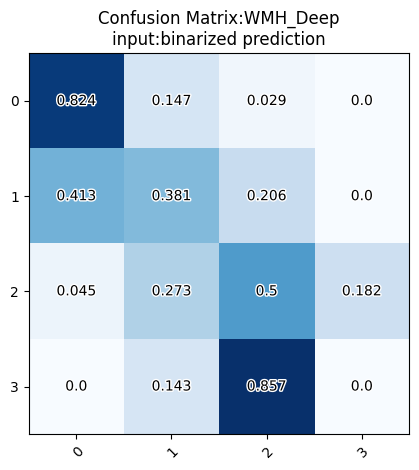

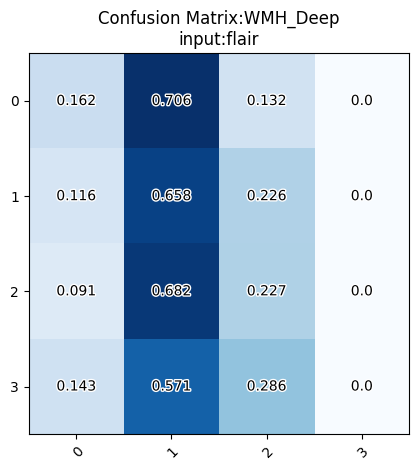

In [230]:
for i in range(len(grp_preds)):
    plot_confusion_matrix_from_results(mean_preds[i], grp_targets[i], names[i], label, "ADNI")

### Now do the CVD results

In [231]:
results_folder = "./results/CVD/"
all_result_files = os.listdir(results_folder)

In [232]:
all_result_files

['.ipynb_checkpoints',
 'CVD_target_fieldPVWMH_channel_idpred_sid2_latentls3_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idseg_sid0_latentls1_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idseg_sid0_latentls3_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid0_latentls1_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid0_latentls2_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid0_latentls3_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid1_latentls1_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid1_latentls2_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid1_latentls3_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid2_latentls1_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid2_latentls2_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid2_latentls3_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid3_latentls1_reweightedtrue',
 'CVD_target_fieldDWMH_channel_idboth_sid3_latentls2_reweightedtrue'

In [250]:
label = "PVWMH"
resdiv = 8
latentls = 3
decay = 0.1
reweighted = "true"
files = [f for f in all_result_files if label in f and f"latentls{latentls}" in f and f"reweighted{reweighted}" in f]

In [251]:
channel_types = ["both", "ent", "pred", "seg", "flair"]
names = ["umap + prediction", "umap", "prediction", "binarized prediction", "flair"]
channel_files = [[],[],[],[],[]]

for i, channel_id in enumerate(channel_types):
    for f in sorted(files):
        if f"channel_id{channel_id}" in f:
            channel_files[i].append(f)

In [252]:
channel_files

[['CVD_target_fieldPVWMH_channel_idboth_sid0_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_idboth_sid1_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_idboth_sid2_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_idboth_sid3_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_idboth_sid4_latentls3_reweightedtrue'],
 ['CVD_target_fieldPVWMH_channel_ident_sid0_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_ident_sid1_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_ident_sid2_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_ident_sid3_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_ident_sid4_latentls3_reweightedtrue'],
 ['CVD_target_fieldPVWMH_channel_idpred_sid0_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_idpred_sid1_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_idpred_sid2_latentls3_reweightedtrue',
  'CVD_target_fieldPVWMH_channel_idpred_sid3_latentls3_reweightedtr

In [253]:
best_idxs = []
for i, file_grp in enumerate(channel_files):
    max_idx = 0
    max_val_acc = 0
    max_test_acc = 0
    for idx, f in enumerate(file_grp):
        try:
            lines = load_preds(f)
        except:
            print(f"failed on {names[i]}:{idx}")
            continue
        # print(len(lines))
        
        val_acc, test_acc = accuracies(lines)
        if val_acc > max_val_acc or (val_acc == max_val_acc and test_acc > max_test_acc):
            max_val_acc = val_acc
            max_idx = idx
            max_test_acc = test_acc 
        print(f"{channel_types[i]}, {val_acc:.3}, {test_acc:.3}")
    print(f"best idx: {max_idx}")
    best_idxs.append(max_idx)

both, 0.582, 0.59
both, 0.66, 0.615
both, 0.668, 0.684
both, 0.676, 0.627
both, 0.648, 0.643
best idx: 3
ent, 0.594, 0.594
ent, 0.635, 0.623
ent, 0.611, 0.59
ent, 0.631, 0.598
ent, 0.648, 0.631
best idx: 4
pred, 0.611, 0.582
pred, 0.635, 0.635
pred, 0.656, 0.635
pred, 0.672, 0.643
pred, 0.648, 0.627
best idx: 3
best idx: 0
best idx: 0


In [254]:
# # lower accuracy may mean better separation though... so I should do majority vote or mean or something
# # yes lets do majority vote....
# for i, file_grp in enumerate(channel_files):
#     best_idx = best_idxs[i]
#     lines = load_preds(file_grp[best_idx])
#     plot_confusion_matrix_from_results(lines[2], lines[3])
#     # break

In [255]:
grp_preds = []
grp_targets = []
for i, file_grp in enumerate(channel_files):
    preds = []
    targets = []
    first = True
    for idx, f in enumerate(file_grp):
        try:
            lines = load_preds(f)
        except:
            print(f"failed on {names[i]}:{idx}")
            continue
        if first:
            targets = lines[3]
            first = False
        preds.append(lines[2])
    
    if len(preds) > 0:
        grp_preds.append(torch.stack(preds))
        grp_targets.append(targets)

In [256]:
mode_preds = [p.mode(dim=0)[0] for p in grp_preds]

In [257]:
mean_preds = [p.type(torch.float32).mean(dim=0).round() for p in grp_preds]

In [258]:
#mean_preds

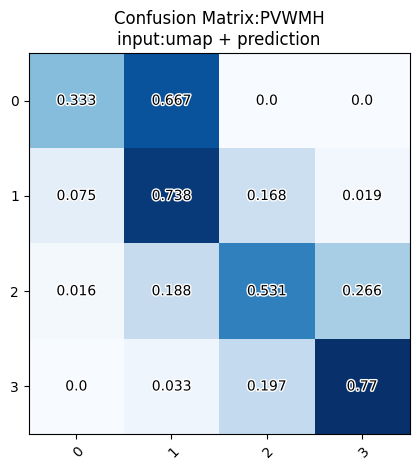

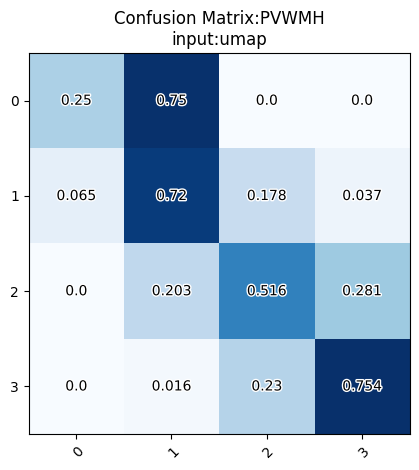

In [ ]:
for i in range(len(grp_preds)):
    plot_confusion_matrix_from_results(mean_preds[i], grp_targets[i], names[i], label, "CVD")

In [42]:
(lines[2] == lines[3]).sum() / len(lines[0])

tensor(0.5164)

In [16]:
values = lines[0].split(": ")[1][:-1].split(", ")

In [18]:
values = values[1:-1] # remove [ and ] symbols

In [19]:
values = [int(v) for v in values]

In [21]:
print(values)

[1, 2, 0, 0, 1, 3, 1, 0, 2, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 3, 0, 1, 2, 1, 0, 2, 0, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 0, 1, 3, 0, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2, 0, 1, 0, 0, 2, 2, 0, 3, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 2, 0, 0, 2, 0, 1, 0, 0, 2, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 2, 2, 1, 1, 2, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 2, 3, 0, 3, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 3, 0, 0, 2, 0, 1, 0, 0, 2, 1, 2, 0, 0, 3, 0, 0, 0, 0, 0, 3, 2, 0, 1, 0, 0, 2, 3, 0, 3, 1, 0, 0, 0, 2, 1, 0, 0, 3, 0, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2]


In [22]:
lines

['preds_val: [1, 1, 2, 0, 0, 1, 3, 1, 0, 2, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 3, 0, 1, 2, 1, 0, 2, 0, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 2, 0, 1, 3, 0, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2, 0, 1, 0, 0, 2, 2, 0, 3, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 0, 1, 2, 0, 0, 2, 0, 1, 0, 0, 2, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 2, 2, 1, 1, 2, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 2, 3, 0, 3, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 3, 0, 0, 2, 0, 1, 0, 0, 2, 1, 2, 0, 0, 3, 0, 0, 0, 0, 0, 3, 2, 0, 1, 0, 0, 2, 3, 0, 3, 1, 0, 0, 0, 2, 1, 0, 0, 3, 0, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2, 0]\n',
 'labels_val: [1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 2.0, 1.0, 0.0,

In [6]:
### building the missing experiments script

In [5]:
len(all_result_files)

115

In [34]:
command_list = """python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 2 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 1 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 2 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 3 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 4 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 0 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 1 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 2 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 3 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 4 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 0 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 1 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 2 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 3 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 4 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 1 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 2 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 3 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 4 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 0 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 1 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 2 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 3 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id ent --seed_index 4 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 0 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 1 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 2 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 3 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 4 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 0 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 1 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 2 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 3 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id seg --seed_index 4 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 0 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 1 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 2 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 3 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id flair --seed_index 4 --layer_div 4 --weight_decay 0.1 --reweighted true --label WMH_Deep
"""

In [35]:
for f in sorted(all_result_files)[1:]:
    command = "python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py"
    selected_channel = None
    for channel_id in ["ent", "pred", "both", "seg", "flair"]:
        if f"_{channel_id}_" in f:
            selected_channel = channel_id
            break
            
    command += f" --channel_id {selected_channel}"
    
    found = False
    for i in range(5):
        if f"_{i}_"in f:
            command += f" --seed_index {i}"
            found = True
            break
    if found == False:
        raise ValueError(f"here 1: {f}")
            
    found = False
    for ld in [4, 8]:
        if f"resdiv{ld}" in f:
            command += f" --layer_div {ld}"
            found = True
            break
    if found == False:
        raise ValueError("here 2")
            
    found = False
    for wd in [0.1, 0.01]:
        if f"decay{wd}" in f:
            command += f" --weight_decay {wd}"
            found = True
            break
    if found == False:
        raise ValueError("here 3")
            
    found = False
    for reweighted in ["true", "false"]:
        if reweighted in f:
            command += f" --reweighted {reweighted}"
            found = True
            break
    if found == False:
        raise ValueError("here 4")
            
    found = False
    for label in ["WMH_Deep", "WMH_PV"]:
        if label in f:
            command += f" --label {label}"
            found = True
            break
    if found == False:
        raise ValueError("here 5")
        
    command += "\n"
    
    print(command)
    # break
    length = len(command_list)
    command_list = command_list.replace(command, "")
    if length == len(command_list):
        raise ValueError
        
command_list.replace("\n\n","\n") 

python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep

python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep

python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 1 --layer_div 8 --weight_decay 0.1 --reweighted false --label WMH_Deep

python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 1 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep

python /home/s220

'python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep\npython /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep\npython /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV\npython /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV\npython /home/s2208943/i

In [36]:
print(command_list)

python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 3 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id pred --seed_index 4 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_PV
python /home/s2208943/ipdis/

In [81]:
genner = torch.Generator().manual_seed(torch.randint(size=(1,), low=0, high=1000).item())

In [87]:
torch.manual_seed(12)

In [88]:
torch.randint(size=(1,), low=0, high=100, generator=genner)

tensor([81])

In [ ]:
os.path.exists(f"/home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/results/ADNI/ADNI_{label}_{channel_id}_{sid}_resdiv{layer_div}_latentls{latent_layers}_{reweighted_id}_decay{weight_decay}")

In [53]:
os.path.exists("/home/s2208943")

True

In [45]:
f

'ADNI_WMH_Deep_ent_0_resdiv8_latentls3_true_decay0.01'

In [46]:
sorted(all_result_files)[1:][0]

'ADNI_WMH_Deep_both_0_resdiv8_latentls3_true_decay0.01'

In [43]:
"--channel_id ent --seed_index 0 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep" in command_list

True

In [41]:
command

'python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_CVD_fazekas_prediction_train.py --channel_id ent --seed_index 0 --layer_div 8 --weight_decay 0.01 --reweighted true --label WMH_Deep'

In [ ]:
python /home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/ADNI_300_analysis/new_fazekas_prediction_code/new_ADNI_fazekas_prediction_train.py --channel_id both --seed_index 0 --layer_div 8 --weight_decay 0.1 --reweighted true --label WMH_Deep